In [26]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchvision.models import googlenet

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
% matplotlib inline


UsageError: Line magic function `%` not found.


### Importing the Dataset into Train and Test

In [27]:
DIR_TRAIN = "/Users/vaaven/PycharmProjects/scientificProject/main/"

### Checking Data Format

In [28]:
imgs = os.listdir(DIR_TRAIN)

print(imgs[:5])

['unsavory.1491.jpg', 'unsavory.494.jpg', 'savory.235.jpg', 'unsavory.3286.jpg', 'unsavory.2198.jpg']


### Class Distribution of male and female

In [29]:
unsavory_list = [img for img in imgs if img.split(".")[0] == "unsavory"]
savory_list = [img for img in imgs if img.split(".")[0] == "savory"]

print("No of cardboard Images: ", len(savory_list))
print("No of glass Images: ", len(unsavory_list))

class_to_int = {"savory": 0, "unsavory": 1}
int_to_class = {0: "savory", 1: "unsavory"}

No of cardboard Images:  5610
No of glass Images:  5610


### Transforms

In [30]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        # T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0), (1, 1, 1))
    ])


def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0), (1, 1, 1))
    ])

### Dataset Class

In [31]:
class TrashDataset(Dataset):

    def __init__(self, imgs, class_to_int, mode="train", transforms=None):

        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, idx):

        image_name = self.imgs[idx]

        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((50, 50))

        if self.mode == "train" or self.mode == "val":

            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype=torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label

        elif self.mode == "test":

            ### Apply Transforms on image
            img = self.transforms(img)

            return img

    def __len__(self):
        return len(self.imgs)


### Splitting data

In [32]:
train_imgs, val_imgs = train_test_split(imgs, test_size=0.25)

### Prepare dataset

In [33]:
train_dataset = TrashDataset(train_imgs, class_to_int, mode="train", transforms=get_train_transform())
val_dataset = TrashDataset(val_imgs, class_to_int, mode="val", transforms=get_train_transform())

train_data_loader = DataLoader(
    dataset=train_dataset,
    num_workers=0,
    batch_size=16,
    shuffle=True
)

val_data_loader = DataLoader(
    dataset=val_dataset,
    num_workers=0,
    batch_size=16,
    shuffle=True
)


### Visualize some Random Images from Training set

tensor([1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.])


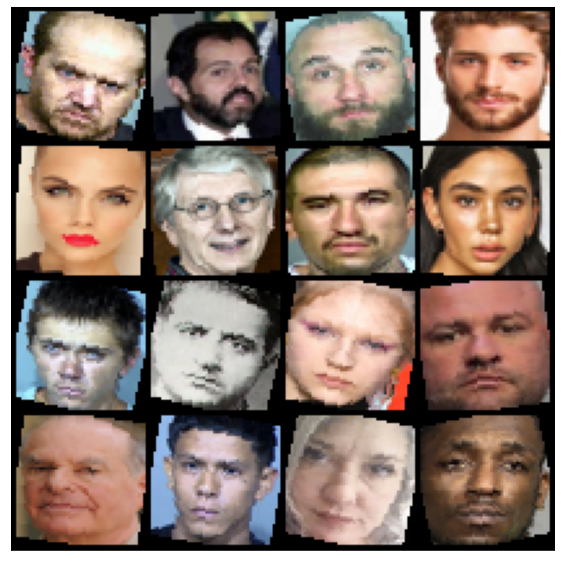

In [34]:
for images, labels in train_data_loader:
    print(labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1, 2, 0))
    break


In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### accuracy

In [36]:
def accuracy(preds, trues):
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]

    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]

    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)

    return (acc * 100)



### train over Epoch

In [42]:
def train_one_epoch(train_data_loader):
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    ###Iterating over data loader
    cnt = 0
    for images, labels in train_data_loader:
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))  # [N, 1] - to match with preds shape

        #Reseting Gradients
        optimizer.zero_grad()

        #Forward
        preds = model(images)

        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

        #Backward
        _loss.backward()
        optimizer.step()

    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time


### Validation - One Epoch

In [43]:
def val_one_epoch(val_data_loader, best_val_acc):
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    ###Iterating over data loader
    for images, labels in val_data_loader:
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))  # [N, 1] - to match with preds shape

        #Forward
        preds = model(images)

        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)

    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), "resnet50_best.pth")

    return epoch_loss, epoch_acc, total_time, best_val_acc


### RESNET50 Pretrained Model

In [44]:
model = resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias=True),
    nn.Sigmoid()
)

In [45]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss": [], "accuracy": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "time": []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

### Train Training and Validation sets

In [46]:
best_val_acc = 0
for epoch in range(epochs):
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)

    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch + 1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)

    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch + 1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))



Training
Epoch 1
Loss : 0.3268
Acc : 86.7506
Time : 659.0505

Validating
Epoch 1
Loss : 0.2363
Acc : 91.4702
Time : 58.9511

Training
Epoch 2
Loss : 0.2145
Acc : 91.7879
Time : 661.6426

Validating
Epoch 2
Loss : 0.2027
Acc : 92.6136
Time : 55.858

Training
Epoch 3
Loss : 0.1627
Acc : 94.1524
Time : 658.8991

Validating
Epoch 3
Loss : 0.1924
Acc : 93.2173
Time : 58.1837

Training
Epoch 4
Loss : 0.1404
Acc : 94.6887
Time : 658.2087

Validating
Epoch 4
Loss : 0.1907
Acc : 93.0398
Time : 55.8483

Training
Epoch 5
Loss : 0.1155
Acc : 95.6979
Time : 657.2823

Validating
Epoch 5
Loss : 0.2206
Acc : 92.5994
Time : 56.3849

Training
Epoch 6
Loss : 0.1115
Acc : 95.865
Time : 664.9948

Validating
Epoch 6
Loss : 0.1999
Acc : 93.6293
Time : 56.8204

Training
Epoch 7
Loss : 0.1107
Acc : 95.7818
Time : 665.517

Validating
Epoch 7
Loss : 0.165
Acc : 94.0341
Time : 55.9407

Training
Epoch 8
Loss : 0.0971
Acc : 97.077
Time : 653.4725

Validating
Epoch 8
Loss : 0.2001
Acc : 93.7713
Time : 55.7195

Trai

### Lets Plot The Accuracies and Losses

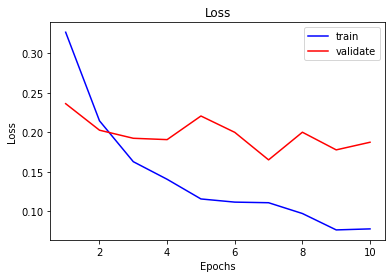

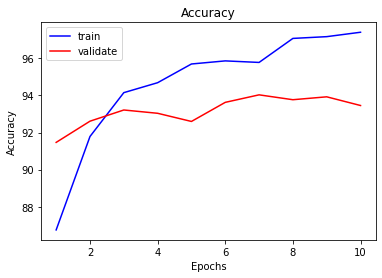

In [47]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color='blue', label="train")
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color='red', label="validate")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color='blue', label="train")
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color='red', label="validate")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Accuracy")
plt.show()


### My network

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 5, padding=3)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=3)
        self.fc1 = nn.Linear(10368, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [53]:
model = Net()

In [54]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss": [], "accuracy": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "time": []}

# Loading model to device
model.to(device)

# No of epochs
epochs = 10

In [55]:
best_val_acc = 0
for epoch in range(epochs):
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)

    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch + 1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)

    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch + 1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

/Users/vaaven/PycharmProjects/scientificProject/venv/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Training
Epoch 1
Loss : 0.5173
Acc : 72.1
Time : 123.4716

Validating
Epoch 1
Loss : 0.4594
Acc : 77.0241
Time : 16.7715

Training
Epoch 2
Loss : 0.4087
Acc : 80.903
Time : 119.4613

Validating
Epoch 2
Loss : 0.3858
Acc : 83.054
Time : 16.6695

Training
Epoch 3
Loss : 0.3704
Acc : 83.2446
Time : 119.3771

Validating
Epoch 3
Loss : 0.3556
Acc : 84.6591
Time : 16.5614

Training
Epoch 4
Loss : 0.3445
Acc : 84.8012
Time : 119.2823

Validating
Epoch 4
Loss : 0.3172
Acc : 86.4702
Time : 16.544

Training
Epoch 5
Loss : 0.3137
Acc : 86.5368
Time : 119.0844

Validating
Epoch 5
Loss : 0.2985
Acc : 87.4645
Time : 16.5852

Training
Epoch 6
Loss : 0.2986
Acc : 87.1546
Time : 119.0472

Validating
Epoch 6
Loss : 0.2868
Acc : 88.0185
Time : 16.5333

Training
Epoch 7
Loss : 0.285
Acc : 88.129
Time : 118.4824

Validating
Epoch 7
Loss : 0.2946
Acc : 87.0312
Time : 16.5499

Training
Epoch 8
Loss : 0.2691
Acc : 88.3294
Time : 118.3527

Validating
Epoch 8
Loss : 0.2628
Acc : 88.5298
Time : 16.4772

Trainin

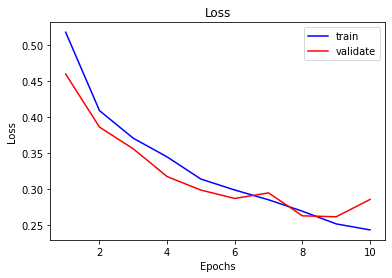

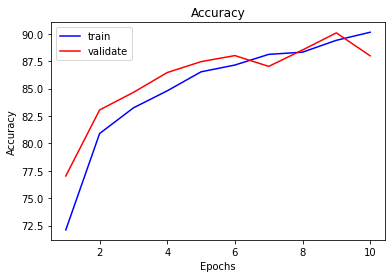

In [56]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color='blue', label="train")
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color='red', label="validate")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color='blue', label="train")
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color='red', label="validate")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Accuracy")
plt.show()